<a href="https://colab.research.google.com/github/SteinwayThor/eeg-features-movies/blob/main/EDA_and_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# generic torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# generic ml/stats imports
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.fftpack as sp
from sklearn.model_selection import train_test_split
from math import pi
from scipy.spatial.distance import pdist, squareform

#torch vision related imports
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

# data utils
import time
import os
import pickle
import json
from PIL import Image
from google.colab import drive
import bz2
import _pickle as cPickle
import pickle as pl

In [2]:
drive.mount('/content/drive', force_remount=True)

# Load any compressed pickle file
def decompress_pickle(file):
  data = bz2.BZ2File(file, 'rb')
  data = cPickle.load(data)
  return data

Mounted at /content/drive


In [3]:
emotion_annotations_f = '/content/drive/MyDrive/Movie Data/e0018RI/emotion_annotations'
emotion_annotations = os.listdir(emotion_annotations_f)
#skyfall_emotion_[angry|fear|sad|happy|disgust]_viewer[123|127|139|142]_chapter[01 to 31].json

In [44]:
#EDA on emotions json data
diff_emotions = {}
diff_viewers = {}
diff_chapters = {}
for json_file in emotion_annotations:
  split_name = json_file.split("_")
  emotion = split_name[2]  #angry
  viewer = split_name[3]  #viewer127
  chapter = split_name[4][:split_name[4].find(".")]  #chapter01
  diff_emotions[emotion] = diff_emotions.get(emotion,[]) + [json_file]
  diff_viewers[viewer] = diff_viewers.get(viewer,[]) + [json_file]
  diff_chapters[chapter] = diff_chapters.get(chapter,[]) + [json_file]
print(sorted(diff_chapters.keys()), diff_emotions.keys(), diff_viewers.keys(), sep='\n-------\n')

['chapter01', 'chapter02', 'chapter03', 'chapter04', 'chapter05', 'chapter06', 'chapter07', 'chapter08', 'chapter09', 'chapter10', 'chapter11', 'chapter12', 'chapter13', 'chapter14', 'chapter15', 'chapter16', 'chapter17', 'chapter18', 'chapter19', 'chapter20', 'chapter21', 'chapter22', 'chapter23', 'chapter24', 'chapter25', 'chapter26', 'chapter27', 'chapter28', 'chapter29', 'chapter30', 'chapter31']
-------
dict_keys(['disgust', 'angry', 'fear', 'sad', 'happy'])
-------
dict_keys(['viewer142', 'viewer127', 'viewer123', 'viewer139'])


In [54]:
#global insight:
# the file name is in the format: skyfall_emotion_[angry|fear|sad|happy|disgust]_viewer[123|127|139|142]_chapter[01 to 31].json

print("\n======================================================================")
print("Total different CHAPTERS for which labels are available along with their count: ")
print("Total CHAPTERS: ", len(diff_chapters.keys()))
chapter_plot = []
for chapter in sorted(list(diff_chapters.keys())):
  print(chapter, ", number of label files: ", len(diff_chapters[chapter]))
  print("Files:", sorted(diff_chapters[chapter]))
  chapter_plot.append([chapter,len(diff_chapters[chapter])])
chapter_plot = np.array(chapter_plot)
#insights:
# 1. I believe that every file for a single chapter represents one particular and different emotion detected in that chapter by random viewers.
# 2. There can be min of 2 and max of 4 emotions per chapter.
# 3. Chapter 32 has no emotions data for it. Implication: Ignore neural data for it.
# 4. We can ignore viewer number in the file name here.

emotion_plot = []
print("\n======================================================================\n")
print("Total different EMOTIONS for which labels are available along with their count: ")
print("Total EMOTIONS: ", len(diff_emotions.keys()))
for emotion in sorted(list(diff_emotions.keys())):
  print(emotion, ", number of label files: ", len(diff_emotions[emotion]), end=',')
  print("Files:", sorted(diff_emotions[emotion]))
  emotion_plot.append([emotion, len(diff_emotions[emotion])])
emotion_plot = np.array(emotion_plot)
#insights:
# 1. 5 total emotions: angry, fear, happy, disgust and sad.
# 2. There is class-imbalance in the emotion classes.
# 3. Most of the data corresponds to negative emotions, possibly because skyfall has a lot of sad and intense scenes.

viewer_plot = []
print("\n======================================================================\n")
print("Total different VIEWERS for which labels are available along with their count: ")
print("Total VIEWERS: ", len(diff_viewers.keys()))
for viewer in sorted(list(diff_viewers.keys())):
  print(viewer, ", number of label files: ", len(diff_viewers[viewer]))
  print("Files:", sorted(diff_viewers[viewer]))
  viewer_plot.append([viewer, len(diff_viewers[viewer])])
viewer_plot = np.array(viewer_plot)
#insights:
# 1. There are 4 distinct viewers but for our purposes, we can just ignore viewer differences in annotation. Assuming no bias in viewers' annotations.


Total different CHAPTERS for which labels are available along with their count: 
Total CHAPTERS:  31
chapter01 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter01.json', 'skyfall_emotion_fear_viewer127_chapter01.json', 'skyfall_emotion_happy_viewer139_chapter01.json', 'skyfall_emotion_sad_viewer123_chapter01.json']
chapter02 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter02.json', 'skyfall_emotion_fear_viewer127_chapter02.json', 'skyfall_emotion_happy_viewer139_chapter02.json', 'skyfall_emotion_sad_viewer123_chapter02.json']
chapter03 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter03.json', 'skyfall_emotion_fear_viewer127_chapter03.json', 'skyfall_emotion_happy_viewer139_chapter03.json', 'skyfall_emotion_sad_viewer123_chapter03.json']
chapter04 , number of label files:  4
Files: ['skyfall_emotion_angry_viewer127_chapter04.json', 'skyfall_emotion_fear_viewer127_chapter04.json', 'skyfall_emotion_happy_v

[]

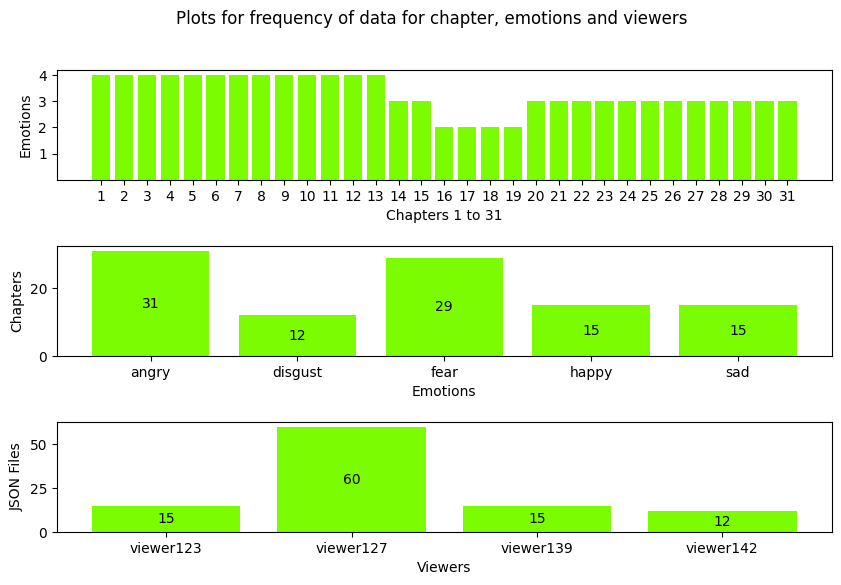

In [130]:
fig, axs = plt.subplots(3,1, figsize=(10,6))
fig.suptitle("Plots for frequency of data for chapter, emotions and viewers")
fig.subplots_adjust(hspace=0.6)

axs[0].bar(range(1,1+chapter_plot.shape[0]),chapter_plot[:,1].astype('int'), color = 'lawngreen')
axs[0].set_xticks(range(1,1+chapter_plot.shape[0]))
axs[0].set_yticks([1,2,3,4])
axs[0].set_ylabel("Emotions")
axs[0].set_xlabel("Chapters 1 to 31")

_ = axs[1].bar(range(1,1+emotion_plot.shape[0]),emotion_plot[:,1].astype('int'), color = 'lawngreen')
axs[1].bar_label(_, label_type='center')
axs[1].set_xticks(range(1,1+emotion_plot.shape[0]), emotion_plot[:,0])
axs[1].set_ylabel("Chapters")
axs[1].set_xlabel("Emotions")

_ = axs[2].bar(range(1,1+viewer_plot.shape[0]),viewer_plot[:,1].astype('int'), color = 'lawngreen')
axs[2].bar_label(_, label_type='center')
axs[2].set_xticks(range(1,1+viewer_plot.shape[0]), viewer_plot[:,0])
axs[2].set_ylabel("JSON Files")
axs[2].set_xlabel("Viewers")
plt.plot()

In [ ]:
f = open(os.path.join(emotion_annotations_f, emotion_annotations[0]))
data = json.load(f)
print(emotion_annotations[0])

json_formatted_str = json.dumps(data, indent=2)
print(json_formatted_str)


In [ ]:
data =
# Create an empty array
#print(data["tracks"])
label_frames = []
for track in data["tracks"]:
    shapes = track["shapes"]
    frame = shapes[0]["frame"]
    attributes = shapes[0]["attributes"]
    if attributes != []:
        emotion = attributes[0]["value"]
        label_frames.append((emotion, frame))

def find_last_frame(data):
    last_frame = 0
    for track in data["tracks"]:
        shapes = track["shapes"][-1]
        frame = shapes["frame"]
        last_frame = frame
    return last_frame

def create_tuple_array(data):
    emotions_frames = []
    current_emotion = "not_angry" #get last emotion from previous dataset
    for i in range(find_last_frame(data)):
        if i in label_frames:
            current_emotion = label_frames[0]
        pair = (current_emotion, i)
        emotions_frames.append(pair)
    return emotions_frames
print(len(create_tuple_array(data)))

In [ ]:
# Load in neural data
# NOTE: Takes a while!
neural_data_folder = '/content/drive/MyDrive/Movie Data/e0018RI/2023-04-02_e0018RI_00'

neural_data_dir = os.listdir(neural_data_folder)

neural_data = {}
channels = []
for f in neural_data_dir:
  channel_name = f[f.rfind('_')+1:-5]
  channels.append(channel_name)
  # channel_data = decompress_pickle(os.path.join(neural_data_folder, f))
  # neural_data[channel_name] = channel_data

print(channels)